In [112]:
import os
import csv
import json
import simpledorff
from collections import defaultdict, Counter
from pprint import pprint
import numpy as np
import itertools
import random
import editdistance

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau

DATA_FILE = '../data/data_with_overlap_scores.json'
SUBMISSION_FILE = '../data/submission_info.json'
PAIRWISE_DIR = '../data/Pairwise/annotated_samples/'

data = []
with open(DATA_FILE, 'r') as f:
    for line in f:
        data.append(json.loads(line))
        
with open(SUBMISSION_FILE, 'r') as f:
    submissions = json.load(f)
    
CHOICE_HEADER = 'Which of A or B more accurately reflects the content of the target summary? (Choices: A, B, Neither)'
pw_annots = dict()
for pw_annot_file in os.listdir(PAIRWISE_DIR):
    if pw_annot_file.endswith('.tsv'):
        _, annotator, _ = pw_annot_file.split('-')
        annot_fpath = os.path.join(PAIRWISE_DIR, pw_annot_file)
        annot_entries = []
        with open(annot_fpath, 'r') as f:
            reader = csv.DictReader(f, delimiter='\t')
            for row in reader:
                row['choice'] = row[CHOICE_HEADER]
                del row[CHOICE_HEADER]
                if row['choice']:
                    annot_entries.append(row)
        pw_annots[annotator.strip()] = annot_entries

print('Pairwise annotations: ')
for annotator, annot_entries in pw_annots.items():
    print(annotator, ': ', len(annot_entries))
    


Pairwise annotations: 
lucy :  102
jay :  99
thinh :  99
yulia :  103
byron :  49


In [113]:
NAME_MAP = {
    'led-base-16384-cochrane': 'LED-base-16k',
    'SciSpace': 'SciSpace',
    'ittc2': 'ITTC-2',
    'ittc1': 'ITTC-1',
    'bart-large-finetuned': 'BART-large',
    'AI2/Longformer BART/train MS2/decode Cochrane': 'LED-MS2',
    'AI2/Longformer BART/Train Cochrane/Decode Cochrane': 'LED-Cochrane',
    'AI2/BART/train Cochrane/decode Cochrane': 'BART-Cochrane',
    'longt5_pubmed': 'LongT5-PubMed'
}

In [114]:
# how many in dataset test set and number with annotations
cochrane = [d for d in data if d['subtask'] == 'Cochrane']
ms2 = [d for d in data if d['subtask'] == 'MS2']

cochrane_annot = [d for d in cochrane if any(entry['annotations'] for entry in d['predictions'])]
ms2_annot = [d for d in ms2 if any(entry['annotations'] for entry in d['predictions'])]

cochrane_metrics = [d for d in cochrane if any(entry['scores'] for entry in d['predictions'])]
ms2_metrics = [d for d in ms2 if any(entry['scores'] for entry in d['predictions'])]

print('Cochrane: ', len(cochrane))
print('w/ annotations: ', len(cochrane_annot))
print('w/ metrics: ', len(cochrane_metrics))
print()

print('MS2: ', len(ms2))
print('w/ annotations: ', len(ms2_annot))
print('w/ metrics: ', len(ms2_metrics))


Cochrane:  274
w/ annotations:  274
w/ metrics:  274

MS2:  0
w/ annotations:  0
w/ metrics:  0


In [115]:
# data_to_analyze keeps Cochrane test examples
# additional fields are added corresponding to facets
data_to_analyze = []
for entry in cochrane:
    for pred in entry['predictions']:
        data_entry = {
            'review_id': entry['review_id'],
            'exp_id': pred['exp_short'],
            'exp_name': submissions[pred['exp_short']]['name'],
            'exp_short': NAME_MAP.get(submissions[pred['exp_short']]['name'], None)
        }
        annot_dict = dict()
        annot_dict['annotated'] = False
        if pred['annotations']:
            annot = pred['annotations'][0]
            if not annot['population']:
                annot['population'] = 0
            if not annot['intervention']:
                annot['intervention'] = 0
            if not annot['outcome']:
                annot['outcome'] = 0
            if not annot['ed_target']:
                annot['ed_target'] = -1
            if not annot['ed_generated']:
                annot['ed_generated'] = -1
            if not annot['strength_target']:
                annot['strength_target'] = 0
            if not annot['strength_generated']:
                annot['strength_generated'] = 0
            annot_dict = {
                'annot_id': annot['annot_id'],
                'Fluency': annot['fluency'] / 2.0,
                'PIO': (annot['population'] + annot['intervention'] + annot['outcome']) / 6.0,
                # new normalized ED (just check if agree)
                'Direction': int(annot['ed_target'] == annot['ed_generated']),
                # old normalized ED (positive-no effect-negative)
                'Direction_old': (2.0 - abs(abs(annot.get('ed_target')) - abs(annot.get('ed_generated')))) / 2.0,
                'Strength': (3.0 - (abs(annot.get('strength_target')) - abs(annot.get('strength_generated')))) / 3.0
            }
            annot_dict['annot_all'] = np.mean([
                annot_dict['Fluency'], 
                annot_dict['PIO'], 
                annot_dict['Direction'], 
                annot_dict['Strength']
            ])
            annot_dict['annotated'] = True
        score_dict = dict()
        score_dict['scored'] = False
        if pred['scores']:
            score_dict = {
                'ROUGE-1': pred['scores']['rouge1_f'],
                'ROUGE-2': pred['scores']['rouge2_f'],
                'ROUGE-L': pred['scores']['rougeL_f'],
                'Avg-ROUGE-F': np.mean([
                    pred['scores']['rouge1_f'],
                    pred['scores']['rouge2_f'],
                    pred['scores']['rougeL_f']
                ]),
                'ROUGE-L-Sum': pred['scores']['rougeLsum_f'],
                'BERTScore-F': pred['scores']['bertscore_f'] if pred['scores']['bertscore_f'] > 0.5 else None,
                'Delta-EI': pred['scores']['ei_score'],
                'ClaimVer': pred['scores']['claimver'],
                'STS': pred['scores']['sts'],
                'NLI': pred['scores']['nli']            
            }
            score_dict['scored'] = True
        overlap_scores_dict = dict()
        overlap_scores_dict['overlap_scored'] = False
        if pred['overlap_scores']:
            overlap_scores_dict = {
                'p_overlap_exact_match': pred['overlap_scores']['exact_match']['PAR'],
                'i_overlap_exact_match': pred['overlap_scores']['exact_match']['INT'],
                'o_overlap_exact_match': pred['overlap_scores']['exact_match']['OUT'],

                'p_overlap_close_match': pred['overlap_scores']['close_match']['PAR'],
                'i_overlap_close_match': pred['overlap_scores']['close_match']['INT'],
                'o_overlap_close_match': pred['overlap_scores']['close_match']['OUT'],

                'p_overlap_substring': pred['overlap_scores']['substring']['PAR'],
                'i_overlap_substring': pred['overlap_scores']['substring']['INT'],
                'o_overlap_substring': pred['overlap_scores']['substring']['OUT'],

                'PIO_overlap_substring': np.mean([
                    pred['overlap_scores']['substring']['PAR'],
                    pred['overlap_scores']['substring']['INT'],
                    pred['overlap_scores']['substring']['OUT'],
                ]),
                'PIO_overlap_exact_match': np.mean([
                    pred['overlap_scores']['exact_match']['PAR'],
                    pred['overlap_scores']['exact_match']['INT'],
                    pred['overlap_scores']['exact_match']['OUT'],
                ]),
                'PIO_overlap_close_match': np.mean([
                    pred['overlap_scores']['close_match']['PAR'],
                    pred['overlap_scores']['close_match']['INT'],
                    pred['overlap_scores']['close_match']['OUT'],
                ]),
            }
            overlap_scores_dict['overlap_scored'] = True
        data_entry.update(annot_dict)
        data_entry.update(score_dict)
        data_entry.update(overlap_scores_dict)
        data_to_analyze.append(data_entry)


In [116]:
print('Number entries: ', len(data_to_analyze))
print('Number annotated: ', len([entry for entry in data_to_analyze if entry['annotated']]))
print('Number scored: ', len([entry for entry in data_to_analyze if entry['scored']]))


Number entries:  2714
Number annotated:  597
Number scored:  2712


In [117]:
pprint(Counter([entry['exp_name'] for entry in data_to_analyze]).most_common())


[('led-base-16384-cochrane', 274),
 ('Concatenate last sentence of each abstract', 274),
 ('SciSpace', 274),
 ('ittc2', 274),
 ('ittc1', 274),
 ('bart-large-finetuned', 272),
 ('AI2/Longformer BART/train MS2/decode Cochrane', 272),
 ('AI2/Longformer BART/Train Cochrane/Decode Cochrane', 272),
 ('AI2/BART/train Cochrane/decode Cochrane', 272),
 ('longt5_pubmed', 256)]


In [118]:
annotated_subset = [entry for entry in data_to_analyze if entry['annotated']]

annotated_by_exp_id = Counter([entry['exp_id'] for entry in annotated_subset])
print('By experiment ID')
print(annotated_by_exp_id)
print()

annotated_by_ann_id = Counter([entry['annot_id'] for entry in annotated_subset])
print('By annotator ID')
print(annotated_by_ann_id)
print()

annotated_by_rev_id = [entry['review_id'] for entry in annotated_subset]
print('By review ID')
counts_by_rev_id = []
for rev_id in set(annotated_by_rev_id):
    counts_by_rev_id.append(annotated_by_rev_id.count(rev_id))
print(Counter(counts_by_rev_id))
print()


print('Number of Cochrane test instances: ', len(set([entry['review_id'] for entry in data_to_analyze])))
print('Number of Cochrane instances with facet annotations: ', len(set(annotated_by_rev_id)))



By experiment ID
Counter({'SPNXTA': 100, 'JB6Z8F': 100, 'VNCH8M': 100, 'PX7SGV': 100, '8FWF5T': 99, 'AQ85CE': 98})

By annotator ID
Counter({1: 333, 0: 264})

By review ID
Counter({1: 162, 2: 52, 6: 50, 3: 9, 4: 1})

Number of Cochrane test instances:  274
Number of Cochrane instances with facet annotations:  274


In [119]:
EXP_W_ANNOTS = set([entry['exp_id'] for entry in data_to_analyze if entry['annotated']])
pprint([submissions[exp]['name'] for exp in EXP_W_ANNOTS])


['bart-large-finetuned',
 'ittc1',
 'AI2/BART/train Cochrane/decode Cochrane',
 'SciSpace',
 'led-base-16384-cochrane',
 'ittc2']


In [120]:
data_to_analyze = [entry for entry in data_to_analyze if entry['exp_id'] in EXP_W_ANNOTS]
df = pd.DataFrame.from_records(data_to_analyze)
display(df)


,review_id,exp_id,exp_name,exp_short,annot_id,Fluency,PIO,Direction,Direction_old,Strength,...,p_overlap_close_match,i_overlap_close_match,o_overlap_close_match,p_overlap_substring,i_overlap_substring,o_overlap_substring,PIO_overlap_substring,PIO_overlap_exact_match,PIO_overlap_close_match,overlap_scored
0,CD000220,SPNXTA,led-base-16384-cochrane,LED-base-16k,0.0,0.5,0.833333,1.0,1.0,1.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
1,CD000220,8FWF5T,SciSpace,SciSpace,0.0,1.0,0.333333,0.0,0.5,0.333333,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
2,CD000220,JB6Z8F,ittc2,ITTC-2,0.0,1.0,1.000000,0.0,0.5,0.333333,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
3,CD000220,AQ85CE,bart-large-finetuned,BART-large,0.0,1.0,0.833333,1.0,1.0,1.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.000000,0.333333,True
4,CD000220,VNCH8M,ittc1,ITTC-1,0.0,1.0,0.333333,0.0,0.5,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,CD003412,8FWF5T,SciSpace,SciSpace,1.0,0.5,0.500000,0.0,0.5,0.666667,...,0.0,0.5,0.0,0.0,0.5,0.0,0.166667,0.000000,0.166667,True
1636,CD003412,JB6Z8F,ittc2,ITTC-2,1.0,1.0,0.166667,0.0,0.5,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
1637,CD003412,AQ85CE,bart-large-finetuned,BART-large,1.0,1.0,0.333333,1.0,1.0,1.000000,...,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,True
1638,CD003412,VNCH8M,ittc1,ITTC-1,1.0,0.0,0.333333,0.0,0.5,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True


In [121]:
df_annot = df[df['annotated'] == True]
display(df_annot)


,review_id,exp_id,exp_name,exp_short,annot_id,Fluency,PIO,Direction,Direction_old,Strength,...,p_overlap_close_match,i_overlap_close_match,o_overlap_close_match,p_overlap_substring,i_overlap_substring,o_overlap_substring,PIO_overlap_substring,PIO_overlap_exact_match,PIO_overlap_close_match,overlap_scored
0,CD000220,SPNXTA,led-base-16384-cochrane,LED-base-16k,0.0,0.5,0.833333,1.0,1.0,1.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
1,CD000220,8FWF5T,SciSpace,SciSpace,0.0,1.0,0.333333,0.0,0.5,0.333333,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
2,CD000220,JB6Z8F,ittc2,ITTC-2,0.0,1.0,1.000000,0.0,0.5,0.333333,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
3,CD000220,AQ85CE,bart-large-finetuned,BART-large,0.0,1.0,0.833333,1.0,1.0,1.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.000000,0.333333,True
4,CD000220,VNCH8M,ittc1,ITTC-1,0.0,1.0,0.333333,0.0,0.5,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,CD003412,8FWF5T,SciSpace,SciSpace,1.0,0.5,0.500000,0.0,0.5,0.666667,...,0.0,0.5,0.0,0.0,0.5,0.0,0.166667,0.000000,0.166667,True
1636,CD003412,JB6Z8F,ittc2,ITTC-2,1.0,1.0,0.166667,0.0,0.5,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
1637,CD003412,AQ85CE,bart-large-finetuned,BART-large,1.0,1.0,0.333333,1.0,1.0,1.000000,...,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,True
1638,CD003412,VNCH8M,ittc1,ITTC-1,1.0,0.0,0.333333,0.0,0.5,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True


In [122]:
# facet annotations per system
Counter(df_annot['exp_id'])

Counter({'SPNXTA': 100,
         '8FWF5T': 99,
         'JB6Z8F': 100,
         'AQ85CE': 98,
         'VNCH8M': 100,
         'PX7SGV': 100})

In [123]:
# distribution of number of systems per review id annotated
counts_per = defaultdict(int)
for rev_id, count in Counter(df_annot['review_id']).items():
    counts_per[count] += 1
    
print(counts_per)


defaultdict(<class 'int'>, {6: 50, 1: 162, 2: 52, 3: 9, 4: 1})


# Distribution of metric scores by system

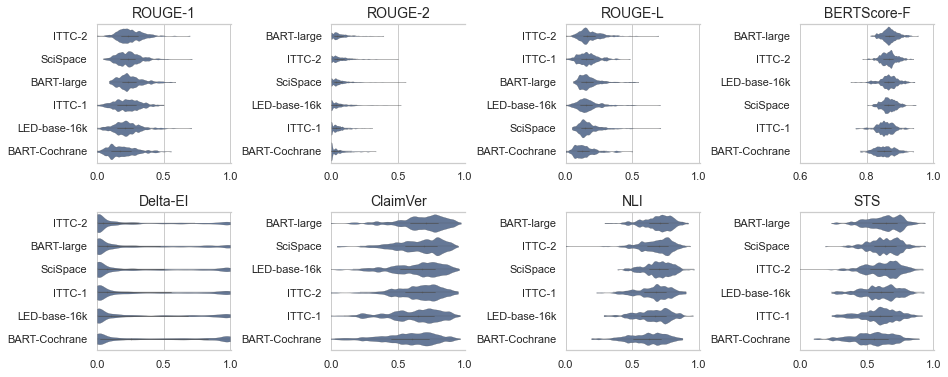

In [124]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid")

metric_means = dict()
metrics_to_plot = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore-F', 'Delta-EI', 'ClaimVer', 'NLI', 'STS']

plt.close()
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
plt.subplots_adjust(wspace=0.75, hspace=0.35)
# fig.suptitle('Distributions of instance-level automated metric values by system', fontsize=16)

y = 'exp_short'
for i, x in enumerate(metrics_to_plot):
    prow = i // 4
    pcol = i % 4
#     print(x, prow, pcol)

    # set palette
    sns.set_color_codes()
    pal = {exp: "b" for exp in df['exp_short'].unique()}

    # sort by median
    grouped = df.groupby([y])
    df2 = pd.DataFrame({col:vals[x] for col,vals in grouped})
    meds = df2.median()
    meds.sort_values(ascending=(x=='Delta-EI'), inplace=True)
    df2 = df2[meds.index]
    
    sns.violinplot(
        ax=axes[prow, pcol], data=df2, orient='h', palette=pal, 
        cut=0, bw=0.1, size=3, aspect=1, linewidth=0.2, saturation=0.5)
    sns.despine(top=False, left=True)
    axes[prow, pcol].set_title(x, fontsize=14)
    if x == 'BERTScore-F':
        axes[prow, pcol].set_xlim(0.6, 1.002)
    else:
        axes[prow, pcol].set_xlim(0.0, 1.005)
    
    # assign to rank dict
    metric_means[x] = dict(df2.mean())

plt.show()
    

In [125]:
system_names = sorted(metric_means['ROUGE-1'].keys())

metric_sorted_sys_dict = dict()
for metric_name, sys_vals in metric_means.items():
    sys_sorted = [(k, v) for k, v in sys_vals.items()]
    if metric_name == 'Delta-EI':
        sys_sorted.sort(key=lambda x: x[1])
    else:
        sys_sorted.sort(key=lambda x: x[1], reverse=True)
    sys_sorted = [(rank, sys, val) for rank, (sys, val) in enumerate(sys_sorted)]
    sys_sorted.sort(key=lambda x: system_names.index(x[1]))
    metric_sorted_sys_dict[metric_name] = sys_sorted
    
metric_names = sorted(metric_sorted_sys_dict.keys())
print('system\t\t' + '\t'.join(metric_names))
print('------------------------------------------------------------------------------------')
for i, sname in enumerate(system_names):
    short_name = '-'.join(sname.replace('/','-').split('-')[:2])
    if short_name.startswith('ITTC'):
        short_name += '\t'
    to_print = [metric_sorted_sys_dict[mname][i] for mname in metric_names]
    print('\t'.join([short_name] + [f'{rank+1}: {val:.3f}' for rank, sys, val in to_print]))
    
    
    

system		BERTScore-F	ClaimVer	Delta-EI	NLI	ROUGE-1	ROUGE-2	ROUGE-L	STS
------------------------------------------------------------------------------------
BART-Cochrane	6: 0.853	6: 0.574	6: 0.401	6: 0.609	6: 0.188	6: 0.042	6: 0.139	6: 0.545
BART-large	1: 0.869	1: 0.671	2: 0.261	2: 0.687	1: 0.248	2: 0.063	2: 0.175	2: 0.626
ITTC-1		5: 0.856	5: 0.620	4: 0.288	4: 0.661	4: 0.224	5: 0.046	5: 0.164	5: 0.592
ITTC-2		2: 0.866	3: 0.652	1: 0.238	3: 0.681	2: 0.247	1: 0.065	1: 0.180	3: 0.618
LED-base	4: 0.865	4: 0.635	5: 0.308	5: 0.655	5: 0.220	3: 0.059	4: 0.167	4: 0.597
SciSpace	3: 0.866	2: 0.659	3: 0.284	1: 0.692	3: 0.235	4: 0.058	3: 0.168	1: 0.631


# Correlation between metrics

In [126]:
# Correlation coefficients for automated metrics
automated_metrics = ["Avg-ROUGE-F", "BERTScore-F", "Delta-EI", "ClaimVer", "NLI", "STS"]

df_metrics = df[automated_metrics]

rho = df_metrics.corr()
pearsoncorr = df_metrics.corr(method=lambda x, y: pearsonr(x, y)[0]) - np.eye(*rho.shape)
pval = df_metrics.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
pdisp = pval.applymap(lambda x: f' ({x:.3f})')
rho = rho.round(3).astype(str) + p
print(rho)

            Avg-ROUGE-F BERTScore-F   Delta-EI  ClaimVer        NLI        STS
Avg-ROUGE-F      1.0***    0.754***    -0.2***  0.394***   0.527***    0.53***
BERTScore-F    0.754***      1.0***  -0.239***   0.52***   0.571***   0.629***
Delta-EI        -0.2***   -0.239***     1.0***   -0.055*  -0.293***  -0.283***
ClaimVer       0.394***     0.52***    -0.055*    1.0***   0.461***   0.552***
NLI            0.527***    0.571***  -0.293***  0.461***     1.0***   0.923***
STS             0.53***    0.629***  -0.283***  0.552***   0.923***     1.0***


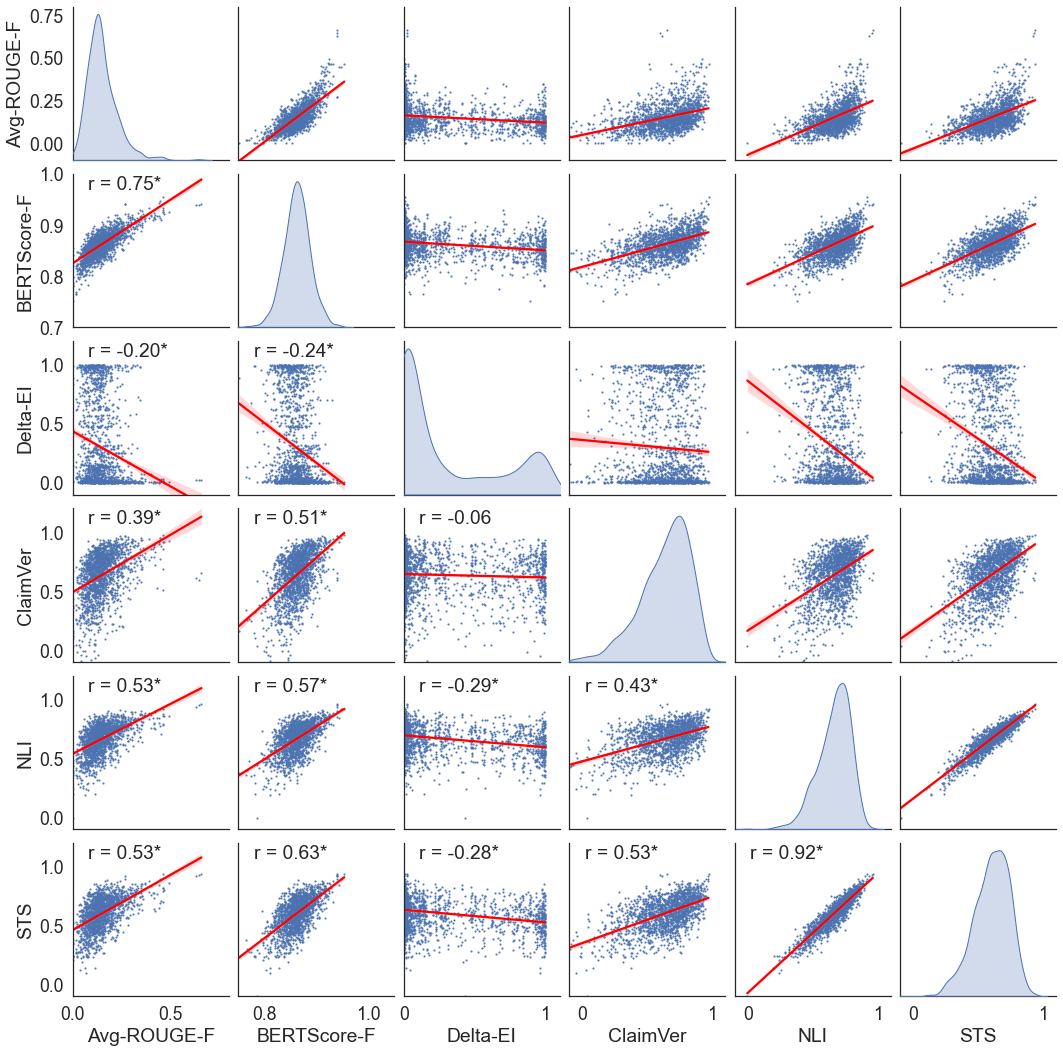

In [127]:
sns.set(font_scale=1.6)
sns.set_style("white")

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    inds_okay = [
        ind for ind, (x, y) in enumerate(zip(x, y)) 
        if (x != float("NaN")) and (0.0 <= x <= 1.0) and (y != float("NaN")) and (0.0 <= y <= 1.0)
    ]
    try:
        r, p = pearsonr(x[inds_okay], y[inds_okay])
    except:
        r = -1
        p = 0.0
    if p <= 0.01:
        add_asterisk = '*'
    else:
        add_asterisk = ''
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.2f}{add_asterisk}', xy=(.1, .9), xycoords=ax.transAxes)

g = sns.pairplot(
    df, 
#     hue="exp_name",
    x_vars=["Avg-ROUGE-F", "BERTScore-F", "Delta-EI", "ClaimVer", "NLI", "STS"],
    y_vars=["Avg-ROUGE-F", "BERTScore-F", "Delta-EI", "ClaimVer", "NLI", "STS"],
    diag_kind="kde",
#     kind="scatter",
#     palette="muted",
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 1.5}
    },
#     corner=True
) 
g.map_lower(corrfunc)

g.axes[0,0].set_ylim((-0.1,0.8))
g.axes[1,0].set_ylim((0.7,1.0))
g.axes[2,0].set_ylim((-0.1,1.2))
g.axes[3,0].set_ylim((-0.1,1.2))
g.axes[4,0].set_ylim((-0.1,1.2))
g.axes[5,0].set_ylim((-0.1,1.2))

g.axes[5,0].set_xlim((0.0,0.8))
g.axes[5,1].set_xlim((0.75,1.05))
g.axes[5,2].set_xlim((0.0,1.1))
g.axes[5,3].set_xlim((-0.1,1.1))
g.axes[5,4].set_xlim((-0.1,1.1))
g.axes[5,5].set_xlim((-0.1,1.1))

plt.show()

In [128]:
df_annot

,review_id,exp_id,exp_name,exp_short,annot_id,Fluency,PIO,Direction,Direction_old,Strength,...,p_overlap_close_match,i_overlap_close_match,o_overlap_close_match,p_overlap_substring,i_overlap_substring,o_overlap_substring,PIO_overlap_substring,PIO_overlap_exact_match,PIO_overlap_close_match,overlap_scored
0,CD000220,SPNXTA,led-base-16384-cochrane,LED-base-16k,0.0,0.5,0.833333,1.0,1.0,1.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
1,CD000220,8FWF5T,SciSpace,SciSpace,0.0,1.0,0.333333,0.0,0.5,0.333333,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
2,CD000220,JB6Z8F,ittc2,ITTC-2,0.0,1.0,1.000000,0.0,0.5,0.333333,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.333333,0.333333,True
3,CD000220,AQ85CE,bart-large-finetuned,BART-large,0.0,1.0,0.833333,1.0,1.0,1.000000,...,0.0,1.0,0.0,0.0,1.0,0.0,0.333333,0.000000,0.333333,True
4,CD000220,VNCH8M,ittc1,ITTC-1,0.0,1.0,0.333333,0.0,0.5,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,CD003412,8FWF5T,SciSpace,SciSpace,1.0,0.5,0.500000,0.0,0.5,0.666667,...,0.0,0.5,0.0,0.0,0.5,0.0,0.166667,0.000000,0.166667,True
1636,CD003412,JB6Z8F,ittc2,ITTC-2,1.0,1.0,0.166667,0.0,0.5,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True
1637,CD003412,AQ85CE,bart-large-finetuned,BART-large,1.0,1.0,0.333333,1.0,1.0,1.000000,...,0.0,0.5,0.0,0.0,0.0,0.0,0.000000,0.000000,0.166667,True
1638,CD003412,VNCH8M,ittc1,ITTC-1,1.0,0.0,0.333333,0.0,0.5,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,True


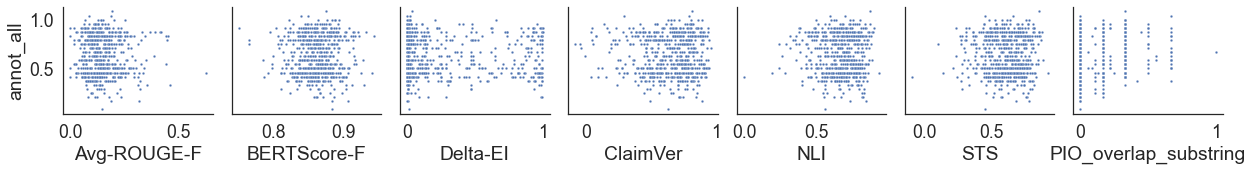

In [129]:
sns.pairplot(
    df_annot, 
#     hue="exp_name",
    diag_kind="kde",
    x_vars=["Avg-ROUGE-F", "BERTScore-F", "Delta-EI", "ClaimVer", "NLI", "STS", "PIO_overlap_substring"],
    y_vars=[
#         "fluency_normalized", "pio_normalized", "ed_normalized", "strength_normalized", 
        "annot_all"
    ],
    kind="scatter",
    plot_kws=dict(s=6),
#     palette="muted",
#     kind="reg", 
#     plot_kws={
#         'line_kws':{'color':'red'},
#         'scatter_kws': {'s': 2}
#     }
)
plt.show()

<Figure size 576x576 with 0 Axes>

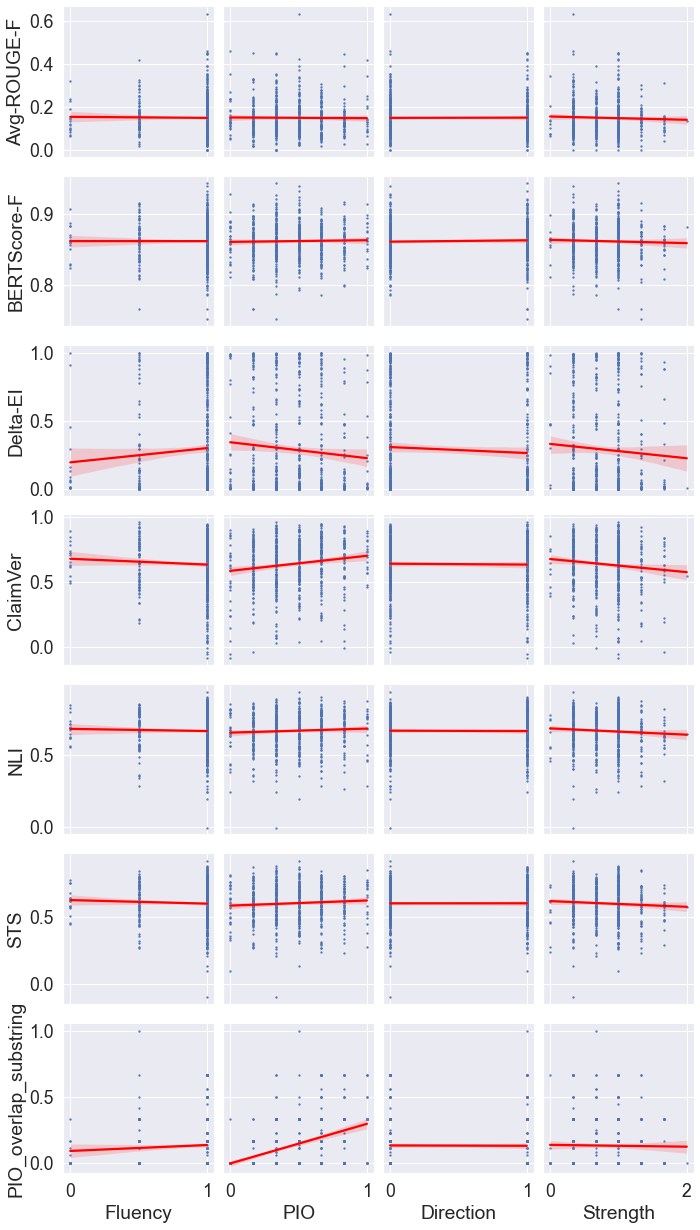

In [130]:
h = plt.figure(figsize=(8, 8))
sns.set(font_scale=1.6)

sns.pairplot(
    df_annot, 
#     hue="exp_name",
    y_vars=["Avg-ROUGE-F", "BERTScore-F", "Delta-EI", "ClaimVer", "NLI", "STS", "PIO_overlap_substring"],
    x_vars=[
        "Fluency", 
        "PIO", 
        "Direction", 
        "Strength", 
#         "annot_all"
    ],
#     kind="scatter",
#     kind="kde",
#     palette="muted"
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 2}
    }
)
plt.show()

In [131]:
# Correlation coefficients for automated metrics
automated_metrics = ["Avg-ROUGE-F", "BERTScore-F", "Delta-EI", "ClaimVer", "NLI", "STS"]
human_facets = ['Fluency', 'PIO', 'Direction', 'Strength']

df_metrics = df[automated_metrics + human_facets]

rho = df_metrics.corr()
pearsoncorr = df_metrics.corr(method=lambda x, y: pearsonr(x, y)[0]) - np.eye(*rho.shape)
pval = df_metrics.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
pdisp = pval.applymap(lambda x: f' ({x:.3f})')
rho = rho.round(4).astype(str) + p

for am in automated_metrics:
    del rho[am]
    
print(rho)

             Fluency        PIO  Direction   Strength
Avg-ROUGE-F  -0.0135    -0.0101     0.0068    -0.0351
BERTScore-F  -0.0002     0.0216     0.0359    -0.0325
Delta-EI      0.0659    -0.0797    -0.0604     -0.054
ClaimVer     -0.0506  0.1421***    -0.0169   -0.0932*
NLI           -0.026     0.0531    -0.0107    -0.0625
STS          -0.0425     0.0663     0.0011    -0.0559
Fluency       1.0***    -0.0203    -0.0025     0.0115
PIO          -0.0203     1.0***    -0.0149    -0.0185
Direction    -0.0025    -0.0149     1.0***  0.4387***
Strength      0.0115    -0.0185  0.4387***     1.0***


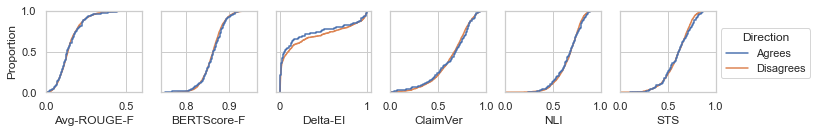

In [132]:
# does Delta-EI measure directional agreement??
metrics_to_plot = ['Avg-ROUGE-F', 'BERTScore-F', 'Delta-EI', 'ClaimVer', 'NLI', 'STS']

sns.set(font_scale=1.0)
sns.set_style("whitegrid")

plt.close()
fig, axes = plt.subplots(1, 6, figsize=(12, 1.5), sharey=True)
plt.subplots_adjust(wspace=0.2)

for i, x in enumerate(metrics_to_plot):
    direction = df['Direction']
    agrees = lambda x: 'Agrees' if x else 'Disagrees'
    direction_cat = pd.Series([agrees(d > 0.5) for d in direction], name='Direction')

    df_ed = pd.concat([direction_cat, df[x]],axis=1)

    # traditional boxplot
    # sns.boxplot(y=df_ed["Direction"], x=df_ed["Delta-EI"])

    # empirical cumulative distribution functions
    final = sns.ecdfplot(ax=axes[i], data=df_ed, x=x, hue="Direction", legend=(i==5))
    
sns.move_legend(final, "upper left", bbox_to_anchor=(1, 0.85))
axes[0].set_xlim(0, 0.6)
axes[3].set_xlim(0, 1)
axes[4].set_xlim(0, 1)
axes[5].set_xlim(0, 1)
    
plt.show()


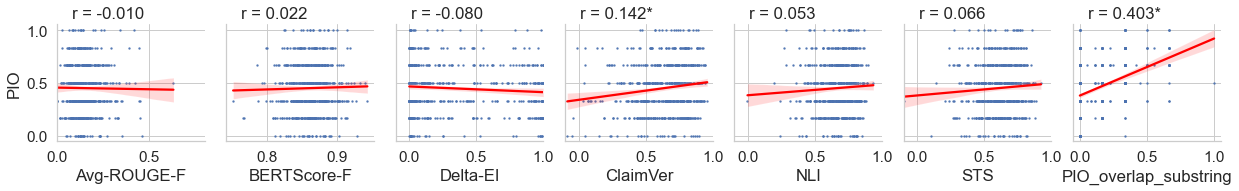

In [133]:
# is anything correlated with human-assessed PIO?

def corrfunc(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    try:
        r, p = pearsonr(x, y)
    except:
        r = -1
        p = 0.0
    if p <= 0.01:
        add_asterisk = '*'
    else:
        add_asterisk = ''
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.3f}{add_asterisk}', xy=(0.1, 1.05), xycoords=ax.transAxes)

sns.set(font_scale=1.4)
sns.set_style("whitegrid")

g = sns.pairplot(
    df_annot, 
    diag_kind="kde",
    x_vars=["Avg-ROUGE-F", "BERTScore-F", "Delta-EI", "ClaimVer", "NLI", "STS", "PIO_overlap_substring"],
    y_vars=['PIO'],
    kind="reg", 
    plot_kws={
        'line_kws':{'color':'red'},
        'scatter_kws': {'s': 2}
    }
)
g.map(corrfunc)

g.axes[0,0].set_xlim((0.0,0.8))
g.axes[0,2].set_xlim((-0.1,1.0))
g.axes[0,3].set_xlim((-0.1,1.0))
g.axes[0,4].set_xlim((-0.1,1.0))
g.axes[0,5].set_xlim((-0.1,1.0))

plt.show()


# System Rankings

In [134]:
score_keys = ["Avg-ROUGE-F", "BERTScore-F", "Delta-EI", "ClaimVer", "NLI", "STS", "PIO_overlap_substring"]

annot_keys = ['Fluency', 'PIO', 'Direction', 'Strength']

corr_vals = []
for score_k, annot_k in itertools.product(score_keys, annot_keys):
    p_r, p_p = pearsonr(df_annot[score_k], df_annot[annot_k])
    s_r, s_p = spearmanr(df_annot[score_k], df_annot[annot_k])
    k_t, k_p = kendalltau(df_annot[score_k], df_annot[annot_k])
    corr_vals.append({
        'score': score_k,
        'annot': annot_k,
        'p_r': p_r,
        'p_p': p_p,
        's_r': s_r,
        's_p': s_p,
        'k_t': k_t,
        'k_p': k_p
    })


In [135]:
# pairwise annotations
exp_ids_in_order = sorted(list(EXP_W_ANNOTS))

def tally_entries(entries):
    tallies = {exp_id: {exp_id2: 0 for exp_id2 in EXP_W_ANNOTS} for exp_id in EXP_W_ANNOTS}
    sums = {exp_id: {exp_id2: 0 for exp_id2 in EXP_W_ANNOTS} for exp_id in EXP_W_ANNOTS}
    for entry in entries:
        a = entry['sys_a']
        b = entry['sys_b']
        pref = entry['choice']
        if pref == 'A':
            tallies[a][b] += 1
        elif pref == 'B':
            tallies[b][a] += 1
        if b > a:
            sums[a][b] += 1
        elif a > b:
            sums[b][a] += 1
        else:
            print('Error!!!')
    
    inferred_pref_count = {exp_id: [] for exp_id in EXP_W_ANNOTS}
    inferred_pref_sys = {exp_id: [] for exp_id in EXP_W_ANNOTS}
    
    for s1 in exp_ids_in_order:
        for s2 in exp_ids_in_order:
            if s1 == s2:
                continue
            elif s2 < s1:
                continue
            else:
                inferred_pref_count[s1].append(tallies[s1][s2])
                inferred_pref_count[s2].append(tallies[s2][s1])
                if tallies[s1][s2] > tallies[s2][s1]:
                    inferred_pref_sys[s1].append(1)
                elif tallies[s2][s1] > tallies[s1][s2]:
                    inferred_pref_sys[s2].append(1)
                    
    pref_count = {k: sum(v) for k, v in inferred_pref_count.items()}
    
    pref_sys = [(k, sum(v)) for k, v in inferred_pref_sys.items()]
    pref_sys.sort(key = lambda x: x[1], reverse = True)
        
    return pref_count, pref_sys  

def get_actual_ranks(ann_rank_dict):
    new_rank_dict = dict()
    for annotator, ranks in ann_rank_dict.items():
        rank_num = 1
        actual_ranks = []
        previous_rank = None
        buffer = 1
        for sys, score in ranks:
            if (not previous_rank):
                pass
            elif score == previous_rank:
                buffer +=1
            else:
                rank_num += buffer
                buffer = 1
            actual_ranks.append((sys, rank_num))
            previous_rank = score
        new_rank_dict[annotator] = actual_ranks

    # use average ranks instead of best rank
    av_dict = dict()
    for annotator, ranks in new_rank_dict.items():
        rank_vals = set([r[1] for r in ranks])
        rank_map = dict()
        for rval in rank_vals:
            num_with_val = sum([1 for r in ranks if r[1] == rval])
            new_val = np.mean(np.linspace(rval, rval+num_with_val-1, num=num_with_val))
            rank_map[rval] = new_val
        new_ranks = [(k, rank_map[v]) for k, v in ranks]
        av_dict[annotator] = new_ranks
        
    return av_dict

def get_global_rank(av_dict):
    total_score = {exp_id: 0 for exp_id in EXP_W_ANNOTS}

    for annotator, ranks in av_dict.items():
        for sys_id, rank in ranks:
            num_points = sum([1 for _, i in ranks if i > rank])
            total_score[sys_id] += num_points

    best_sys = [(k, v) for k, v in total_score.items()]
    best_sys.sort(key=lambda x: x[1], reverse=True)
    return best_sys



In [136]:
# get complete inferred ranks
inferred_preferences_counts = dict()
inferred_preferences_sys = dict()
for annotator, annot_entries in pw_annots.items():
    pref_count, pref_sys = tally_entries(annot_entries)
    inferred_preferences_counts[annotator] = pref_count
    inferred_preferences_sys[annotator] = pref_sys
    
# each ranker's full ranks   
av_rank_dict = get_actual_ranks(inferred_preferences_sys)
annotators = list(av_rank_dict.keys())
annotators.sort()
print('\t\t'.join(annotators))
print('--------------------------------------------------------------------')
for i in [0, 1, 2, 3, 4, 5]:
    to_print = ''
    for ann in annotators:
        entry = av_rank_dict[ann][i]
        to_print += f'{entry[1]}: {entry[0]}' + '\t'
    print(to_print)
    
global_rank = get_global_rank(av_rank_dict)

print()
print('Rank order by pairwise preferences')
print()
print('rank\tpoints\tsys_id\tsys_name')
print('-----------------------------------------')
for i, (k, v) in enumerate(global_rank):
    print(f'{i+1}\t{v}\t{k}\t{submissions[k]["name"]}')


byron		jay		lucy		thinh		yulia
--------------------------------------------------------------------
1.0: VNCH8M	1.5: VNCH8M	1.0: VNCH8M	1.0: JB6Z8F	2.0: AQ85CE	
2.0: SPNXTA	1.5: SPNXTA	2.5: SPNXTA	2.5: AQ85CE	2.0: VNCH8M	
3.0: AQ85CE	3.0: AQ85CE	2.5: JB6Z8F	2.5: PX7SGV	2.0: JB6Z8F	
4.0: JB6Z8F	4.5: PX7SGV	4.5: AQ85CE	4.5: VNCH8M	4.0: 8FWF5T	
5.5: PX7SGV	4.5: JB6Z8F	4.5: PX7SGV	4.5: 8FWF5T	5.0: SPNXTA	
5.5: 8FWF5T	6.0: 8FWF5T	6.0: 8FWF5T	6.0: SPNXTA	6.0: PX7SGV	

Rank order by pairwise preferences

rank	points	sys_id	sys_name
-----------------------------------------
1	18	VNCH8M	ittc1
2	14	JB6Z8F	ittc2
3	13	AQ85CE	bart-large-finetuned
4	12	SPNXTA	led-base-16384-cochrane
5	5	PX7SGV	AI2/BART/train Cochrane/decode Cochrane
6	3	8FWF5T	SciSpace


In [137]:
# bootstrap resample to estimate combined ranking stability
n_samples = 10000
sample_prop = 1.0

bs_pref_sys = []
while n_samples > 0:
    ann_pref_sys = dict()
    for annotator, annot_entries in pw_annots.items():
        num_to_sample = int(sample_prop * len(annot_entries))
        annot_sample = random.choices(annot_entries, k=num_to_sample)
        pref_count, pref_sys = tally_entries(annot_sample)
        ann_pref_sys[annotator] = pref_sys
    av_ranks = get_actual_ranks(ann_pref_sys)
    sum_ranks = get_global_rank(av_ranks)
    bs_pref_sys.append(sum_ranks)
    n_samples -= 1
    
full_global_ranks = [i[0] for i in global_rank]
global_rank_inds = [1, 2, 3, 4, 5, 6]

edit_distances = []
spearman_rhos = []
kendall_taus = []
for sum_ranks in bs_pref_sys:
    # compute edit distance
    partial_ranks = [i[0] for i in sum_ranks]
    edist = editdistance.eval(full_global_ranks, partial_ranks)
    edit_distances.append(edist)
    
    # compute spearman corr
    sum_rank_dict = {k: i+1 for i, (k, v) in enumerate(sum_ranks)}
    partial_rank_inds = [sum_rank_dict[sys] for sys in full_global_ranks]
    r, p = spearmanr(partial_rank_inds, global_rank_inds)
    spearman_rhos.append((r, p))
    
    tau, p = kendalltau(partial_rank_inds, global_rank_inds)
    kendall_taus.append((tau, p))
    
print(Counter(edit_distances))

rs = [i[0] for i in spearman_rhos]
sigs = sum([1 for i in spearman_rhos if i[1] <= 0.05]) / len(spearman_rhos)
print(f'Average Spearman rho: {np.mean(rs):.3f} ({np.std(rs):.3f})')
print(f'Proportion Spearman correlations significant: {sigs:.03f}')
    

Counter({2: 4171, 4: 2827, 3: 1931, 5: 543, 0: 517, 6: 11})
Average Spearman rho: 0.738 (0.188)
Proportion Spearman correlations significant: 0.450


<AxesSubplot:>

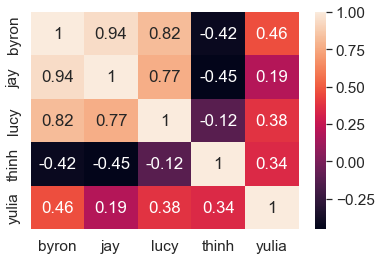

In [138]:
# Spearman rank tests between annotators (Pairwise annotation rankings)
sys_list = list(EXP_W_ANNOTS)
spearman_coeffs = dict()
for ann1, ann2 in itertools.product(av_rank_dict, av_rank_dict):
    ann1_ranks = [i[1] for i in sorted(av_rank_dict[ann1], key=lambda x: sys_list.index(x[0]))]
    ann2_ranks = [i[1] for i in sorted(av_rank_dict[ann2], key=lambda x: sys_list.index(x[0]))]
    res = spearmanr(ann1_ranks, ann2_ranks)
    spearman_coeffs[(ann1, ann2)] = res

ser = pd.Series([res.correlation for res in list(spearman_coeffs.values())],
    index=pd.MultiIndex.from_tuples(spearman_coeffs.keys()))
df_corr = ser.unstack().fillna(0)

sns.heatmap(df_corr, annot=True)


In [139]:
# Spearman correlation coefficient between each individual pairwise annotator and the ranking from the global vote tally
sys_list = list(EXP_W_ANNOTS)
best_sys = global_rank
global_spearman_coeffs = dict()
global_best_sys = [(entry[0], i+1) for i, entry in enumerate(best_sys)]
global_ranks = [i[1] for i in sorted(global_best_sys, key=lambda x: sys_list.index(x[0]))]
for ann, ranks in av_rank_dict.items():
    ann_ranks = [i[1] for i in sorted(av_rank_dict[ann], key=lambda x: sys_list.index(x[0]))]
    res = spearmanr(global_ranks, ann_ranks)
    global_spearman_coeffs[ann] = res
  
print('Annotator\tSpearman R\tp-value')
print('---------------------------------------')
for ann, res in global_spearman_coeffs.items():
    print(f'{ann}\t\t{res.correlation:.3f}\t\t{res.pvalue:.3f}')



Annotator	Spearman R	p-value
---------------------------------------
lucy		0.853		0.031
jay		0.618		0.191
thinh		0.235		0.653
yulia		0.759		0.080
byron		0.754		0.084


In [144]:
# all rankings by automated metrics and human eval scores
sys_list = list(EXP_W_ANNOTS)
metrics = {
    'M1: Avg-ROUGE-F': "Avg-ROUGE-F", 
    'M2: BERTScore-F': "BERTScore-F", 
    'M3: Delta-EI': "Delta-EI", 
    'M4: ClaimVer': "ClaimVer", 
    'M5: NLI': "NLI", 
    'M6: STS': "STS",
    'M7: PIO-overlap': "PIO_overlap_substring"
}
ann_metrics = {
#     'Facet-Combined': 'annot_all', 
    'F1: Fluency': 'Fluency', 
    'F2: PIO': 'PIO', 
    'F3: Direction': 'Direction', 
    'F4: Strength': 'Strength'
}

reverse = {"Delta-EI"}

all_rankings = dict()
for key, metric in metrics.items():
    order = dict(df_annot.groupby(by=["exp_id"])[metric].mean().sort_values(ascending=False))
    order_sorted = [(k, v) for k, v in order.items()]
    order_sorted.sort(key=lambda x: x[1], reverse=not(metric in reverse))
    ranks = {k: i+1 for i, (k, _) in enumerate(order_sorted)}
    all_rankings[key] = ranks
    
for key, column in ann_metrics.items():
    order = dict(df_annot.groupby(by=["exp_id"])[column].mean().sort_values(ascending=False))
    order_sorted = [(k, v) for k, v in order.items()]
    order_sorted.sort(key=lambda x: x[1], reverse=not(metric in reverse))
    ranks = {k: i+1 for i, (k, _) in enumerate(order_sorted)}
    all_rankings[key] = ranks
    
all_rankings['Pairwise-Combined'] = {k: v for k, v in global_best_sys}


<AxesSubplot:>

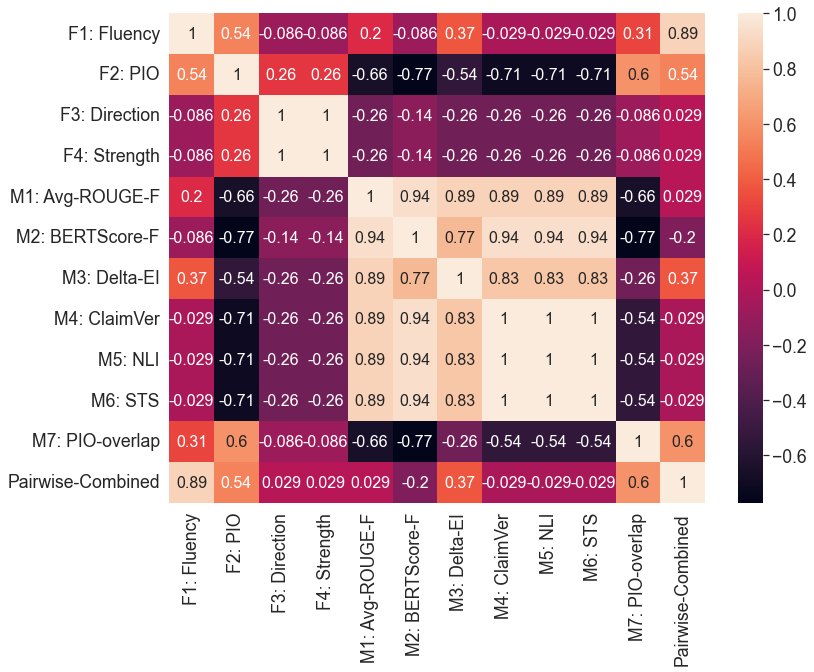

In [145]:
# Spearman correlations between different metrics
sys_list = list(EXP_W_ANNOTS)
spearman_coeffs = dict()
for met1, met2 in itertools.product(all_rankings, all_rankings):
    met1_ranks = [all_rankings[met1][sys] for sys in sys_list]
    met2_ranks = [all_rankings[met2][sys] for sys in sys_list]
    res = spearmanr(met1_ranks, met2_ranks)
    spearman_coeffs[(met1, met2)] = res

ser = pd.Series([res.correlation for res in list(spearman_coeffs.values())],
    index=pd.MultiIndex.from_tuples(spearman_coeffs.keys()))
df_corr = ser.unstack().fillna(0)

h = plt.figure(figsize=(12, 9))
sns.set(font_scale=1.6)
sns.heatmap(df_corr, annot=True, annot_kws={"size":16})


In [142]:
# table of rankings for all metrics
best_sys_order = full_global_ranks
fields = list(metrics.keys()) + list(ann_metrics.keys()) + ['Pairwise-Combined']
print('System\t' + ' '.join([f.split(':')[-1][:10] for f in fields]))
    
for sys in best_sys_order:
    to_print = submissions[sys]["name"][:8] + '\t'
    if submissions[sys]["name"].startswith('ittc'):
        to_print += '\t'
    for f in fields:
        entry = all_rankings[f][sys]
        to_print += f'{entry}' + '\t'
    print(to_print)   


System	 Avg-ROUGE  BERTScore  Delta-EI  ClaimVer  NLI  STS  PIO-overl  Fluency  PIO  Direction  Strength Pairwise-C
ittc1		5	5	4	4	4	4	1	2	1	3	3	1	
ittc2		1	2	1	2	2	2	2	1	4	6	6	2	
bart-lar	3	3	2	3	3	3	6	4	5	2	2	3	
led-base	4	4	5	5	5	5	3	3	2	1	1	4	
AI2/BART	6	6	6	6	6	6	4	5	3	5	5	5	
SciSpace	2	1	3	1	1	1	5	6	6	4	4	6	


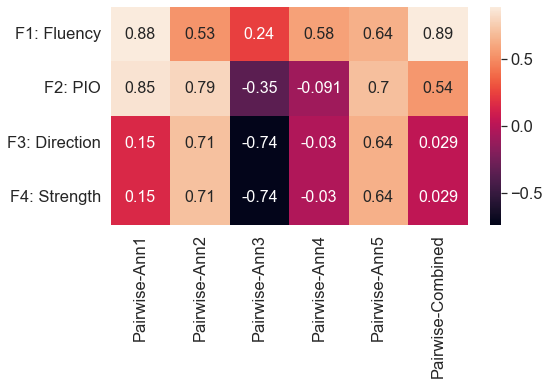

In [143]:
# spearman rank correlations between individual voters and facet annotations
ind_rankings = dict()
ind_rankings['Pairwise-Combined'] = {k: v for k, v in global_best_sys}
for i, (ann, ranks) in enumerate(av_rank_dict.items()):
    ind_rankings[f'Pairwise-Ann{i+1}'] = {k: v for k, v in ranks}
    
for key, column in ann_metrics.items():
    order = dict(df_annot.groupby(by=["exp_id"])[column].mean().sort_values(ascending=False))
    order_sorted = [(k, v) for k, v in order.items()]
    order_sorted.sort(key=lambda x: x[1], reverse=not(metric in reverse))
    ranks = {k: i+1 for i, (k, _) in enumerate(order_sorted)}
    ind_rankings[key] = ranks

sys_list = list(EXP_W_ANNOTS)
spearman_coeffs = dict()
for met1, met2 in itertools.product(ind_rankings, ind_rankings):
    if (met2.startswith('Pairwise') and met1.startswith('F')):
        met1_ranks = [ind_rankings[met1][sys] for sys in sys_list]
        met2_ranks = [ind_rankings[met2][sys] for sys in sys_list]
        res = spearmanr(met1_ranks, met2_ranks)
        spearman_coeffs[(met1, met2)] = res

ser = pd.Series([res.correlation for res in list(spearman_coeffs.values())],
    index=pd.MultiIndex.from_tuples(spearman_coeffs.keys()))
df_corr = ser.unstack()

h = plt.figure(figsize=(8, 4)) 
sns.set(font_scale=1.5)
sns.heatmap(df_corr, annot=True, annot_kws={"size":16})
plt.show()

